In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [5]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_rmse_perc'
metric_filter_2 = 'test_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.07, 0.03, 0.9)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [len(dataset_val.node_attributes)] * 2],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
        )

100%|██████████| 24/24 [01:03<00:00,  2.66s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 391/391 [00:16<00:00, 23.96it/s]


In [10]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.38302477664046686,
 'epoch': 30,
 'train_loss': 0.046844903,
 'val_loss': 0.039995342,
 'train_acc': 0.40952378511428833,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.19676691,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[10_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_30',
 'train_rmse': 0.8890872794479687,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.8977337722988514,
 'train_mae': 0.6571428571428571,
 'val_mae': 0.5111111111111111,
 'test_mae': 0.6474074074074074,
 'train_mcc': 0.26921384733883347,
 'test_mcc': 0.26848309052594627,
 '

In [11]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [4, 4],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.37403179906912004,
 'epoch': 20,
 'train_loss': 0.048385832,
 'val_loss': 0.037016224,
 'train_acc': 0.3523809313774109,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.18857415,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.56_4_[4_4]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_20',
 'train_rmse': 0.9206622874969125,
 'val_rmse': 0.8027729719194864,
 'test_rmse': 0.9733485539144789,
 'train_mae': 0.7142857142857143,
 'val_mae': 0.5111111111111111,
 'test_mae': 0.7044444444444444,
 'train_mcc': 0.24547362305411116,
 'test_mcc': 0.25258721305776244,
 'test_ac

In [12]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': False,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'val_mcc': 0.353117281644018,
 'epoch': 50,
 'train_loss': 0.045746442,
 'val_loss': 0.041118756,
 'train_acc': 0.43809521198272705,
 'val_acc': 0.5333331823348999,
 'val_rmse_perc': 0.19824325,
 'model_class': 'fnn',
 'path_name': 'saved_fnn\\0.53_4_[10_15]_4_ReLU()_None_0.0_0.1_adamw_max_val_mcc_False_mse_dist_10_False_0_50',
 'train_rmse': 0.839500985563391,
 'val_rmse': 0.8563488385776752,
 'test_rmse': 0.896908269804914,
 'train_mae': 0.6095238095238096,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6503703703703704,
 'train_mcc': 0.3214265034262203,
 'test_mcc': 0.2587214650743106,
 'test_a

In [13]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 391/391 [00:00<00:00, 24501.71it/s]


In [14]:
cm = all[sort_idx[0]]['test_cm'][0]

In [15]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

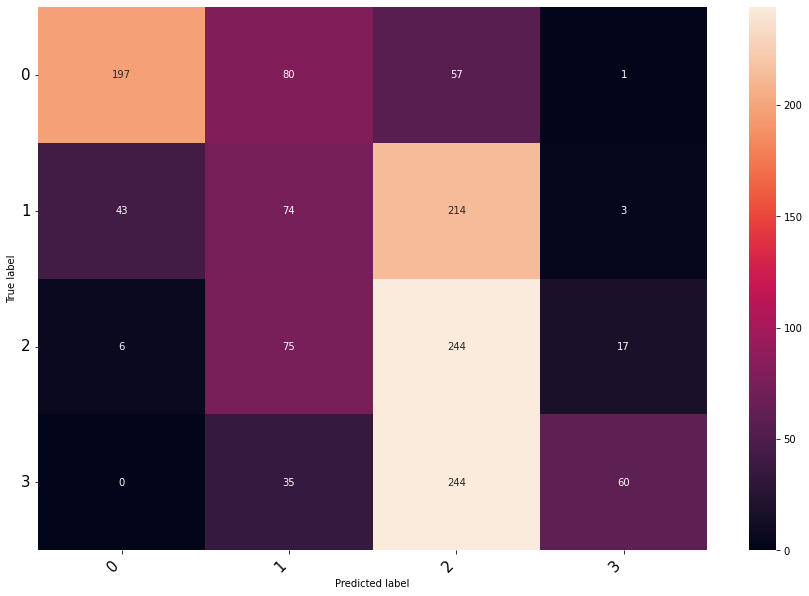

In [16]:
cm.visualize()

In [17]:
cm.class_accuracy

tensor([0.5881, 0.2216, 0.7135, 0.1770])

In [18]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.21514669, 0.2191761, 0.13746823, 0.25695646]

In [19]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.16714726, 0.19360907, 0.107007526, 0.23403561]

### GCN

In [20]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [21]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 72/72 [06:42<00:00,  5.58s/it]


#### Results

In [22]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 1125/1125 [01:03<00:00, 17.80it/s]


In [23]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4062103742297434,
 'epoch': 80,
 'train_loss': 0.05294896,
 'val_loss': 0.043282386,
 'train_acc': 0.34285712242126465,
 'val_acc': 0.5555554032325745,
 'val_rmse_perc': 0.19939438,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.56_4_[5_10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0_80',
 'train_rmse': 0.9561828874675149,
 'val_rmse': 0.8819171036881969,
 'test_rmse': 0.8823369642707476,
 'train_mae': 0.7428571428571429,
 'val_mae': 0.5555555555555556,
 'test_mae': 0.6362962962962962,
 'train_mcc': 0.2700835773592458,
 'tes

In [24]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.4255173576236087,
 'epoch': 23,
 'train_loss': 0.07197032,
 'val_loss': 0.039804712,
 'train_acc': 0.32380950450897217,
 'val_acc': 0.577777624130249,
 'val_rmse_perc': 0.1903928,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.58_4_[5_10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0.2',
 'train_rmse': 0.9611501047232549,
 'val_rmse': 0.7888106377466155,
 'test_rmse': 0.9034911711224943,
 'train_mae': 0.7523809523809524,
 'val_mae': 0.4888888888888889,
 'test_mae': 0.6474074074074074,
 'train_mcc': 0.19641604752183273,
 't

In [25]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'tr_par_lr': 0.1,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.4447703905529441,
 'epoch': 100,
 'train_loss': 0.055146668,
 'val_loss': 0.045295734,
 'train_acc': 0.3333333134651184,
 'val_acc': 0.577777624130249,
 'val_rmse_perc': 0.20493978,
 'model_class': 'gcn',
 'path_name': 'saved_gcn\\0.58_4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_True_mse_dist_10_True_0',
 'train_rmse': 0.9461702252967461,
 'val_rmse': 0.8692269873603532,
 'test_rmse': 0.8877770824639191,
 'train_mae': 0.7428571428571429,
 'val_mae': 0.5333333333333333,
 'test_mae': 0.6444444444444445,
 'train_mcc': 0.2480288187609099,
 'test_m

In [26]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1125/1125 [00:00<00:00, 22559.94it/s]


### GraphSAGE

In [27]:
save_model = f'{save_path}_sage_dist'
log_dir = f'{log_path}_sage_dist'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 168/168 [3:41:27<00:00, 79.09s/it]   


#### Results

In [29]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 2384/2384 [14:38<00:00,  2.71it/s]


True

In [30]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.6780291853268765,
 'epoch': 70,
 'train_loss': 0.012978804,
 'val_loss': 0.013352137,
 'train_acc': 0.952380895614624,
 'val_acc': 0.7555553913116455,
 'val_rmse_perc': 0.11611595,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.76_4_[20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2_70',
 'train_rmse': 0.21821789023599236,
 'val_rmse': 0.4944132324730442,
 'test_rmse': 0.5517648452415617,
 'train_mae': 0.047619047619047616,
 'val_mae': 0.24444444444444444,
 'test_mae': 0.2614814814814815,
 'tr

In [31]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5892567447946704,
 'epoch': 100,
 'train_loss': 0.013825611,
 'val_loss': 0.014405977,
 'train_acc': 0.9238094687461853,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.10469946,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.69_4_[20_20]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2_100',
 'train_rmse': 0.3236694374850748,
 'val_rmse': 0.5577733510227171,
 'test_rmse': 0.6,
 'train_mae': 0.08571428571428572,
 'val_mae': 0.3111111111111111,
 'test_mae': 0.30814814814814817,
 'train_mcc': 0.89

In [32]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20, 20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.6780291853268765,
 'epoch': 70,
 'train_loss': 0.012978804,
 'val_loss': 0.013352137,
 'train_acc': 0.952380895614624,
 'val_acc': 0.7555553913116455,
 'val_rmse_perc': 0.11611595,
 'model_class': 'sage',
 'path_name': 'saved_sage_dist\\0.76_4_[20_20]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2_70',
 'train_rmse': 0.21821789023599236,
 'val_rmse': 0.4944132324730442,
 'test_rmse': 0.5517648452415617,
 'train_mae': 0.047619047619047616,
 'val_mae': 0.24444444444444444,
 'test_mae': 0.2614814814814815,
 'tr

In [33]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2384/2384 [00:00<00:00, 23435.05it/s]


#### cm

In [34]:
cm = all[sort_idx[0]]['test_cm'][0]

In [35]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

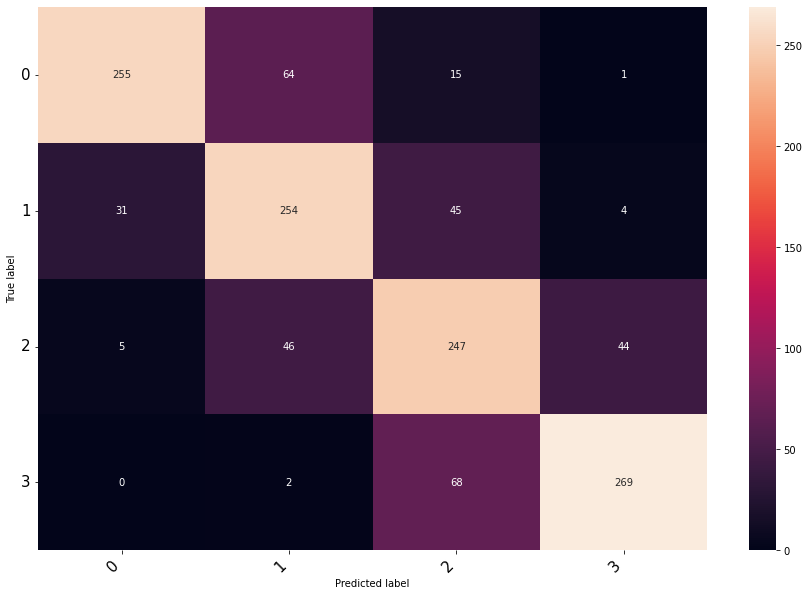

In [36]:
cm.visualize()

In [37]:
cm.class_accuracy

tensor([0.7612, 0.7605, 0.7222, 0.7935])

In [38]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.13826792, 0.121879995, 0.11518124, 0.11067404]

In [39]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08407375, 0.081279375, 0.08210248, 0.08766373]

#### GraphSAGE Base_n

In [40]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [41]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='base_n',
        )

100%|██████████| 336/336 [3:48:32<00:00, 40.81s/it]   


##### Results

In [42]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='base_n',
)

toast.show_toast("Done")

100%|██████████| 3822/3822 [14:24<00:00,  4.42it/s]


True

In [43]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5704468701236257,
 'epoch': 44,
 'train_loss': 0.017958645,
 'val_loss': 0.03838609,
 'train_acc': 0.7333332896232605,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.16241625,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.69_4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0.2',
 'train_rmse': 0.5163977794943222,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.6253887679764573,
 'train_mae': 0.26666666666666666,
 'val_mae': 0.35555555555555557,
 'test_mae': 0.36,
 'train_mcc'

In [44]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'right',
 'norm_nodes': None,
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5356709062830057,
 'epoch': 39,
 'train_loss': 0.025255827,
 'val_loss': 0.026946953,
 'train_acc': 0.4952380657196045,
 'val_acc': 0.6666665077209473,
 'val_rmse_perc': 0.15957984,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.67_4_[30]_1_lstm_right_None_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0',
 'train_rmse': 0.749603069567329,
 'val_rmse': 0.6324555320336759,
 'test_rmse': 0.807832032413046,
 'train_mae': 0.5238095238095238,
 'val_mae': 0.35555555555555557,
 'test_mae': 0.534074074074074,
 'train_mcc': 0

In [45]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [15, 15, 15],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'base_n',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.5704468701236257,
 'epoch': 44,
 'train_loss': 0.017958645,
 'val_loss': 0.03838609,
 'train_acc': 0.7333332896232605,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.16241625,
 'model_class': 'sage',
 'path_name': 'saved_sage_base\\0.69_4_[15_15_15]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_base_n_10_True_0.2',
 'train_rmse': 0.5163977794943222,
 'val_rmse': 0.6666666666666666,
 'test_rmse': 0.6253887679764573,
 'train_mae': 0.26666666666666666,
 'val_mae': 0.35555555555555557,
 'test_mae': 0.36,
 'train_mcc'

In [46]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 3822/3822 [00:00<00:00, 24565.57it/s]


##### cm

In [47]:
cm = all[sort_idx[0]]['test_cm'][0]

In [48]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

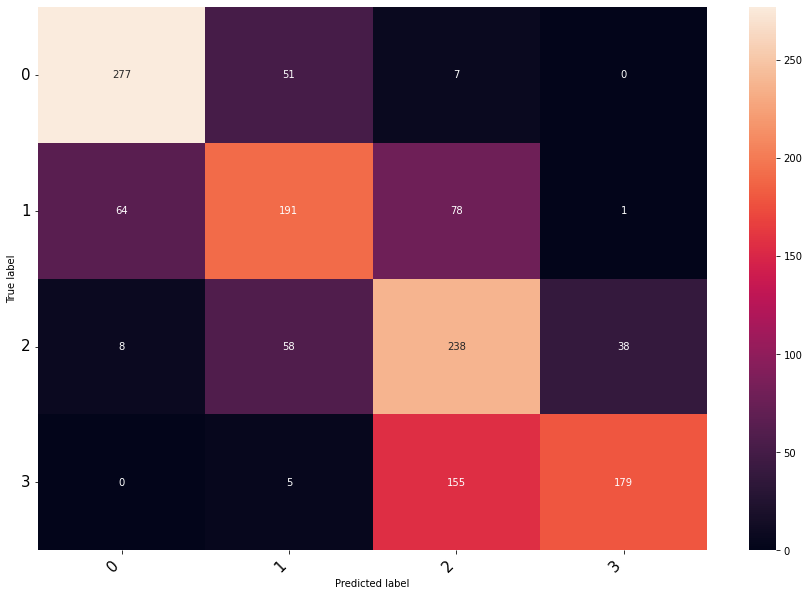

In [49]:
cm.visualize()

In [50]:
cm.class_accuracy

tensor([0.8269, 0.5719, 0.6959, 0.5280])

In [51]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.11855963, 0.15000962, 0.12546395, 0.17391637]

In [52]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.083212174, 0.113725506, 0.09397478, 0.14563991]

#### GraphSAGE Scale

In [53]:
save_model = f'{save_path}_sage_scale'
log_dir = f'{log_path}_sage_scale'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[15] * 3, [20], [15], [20] * 2, [15] * 2, [25], [30]], 
    out_features = [out_feats],
    aggregator_type = ['mean', 'lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [54]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            approach='scale',
        )

100%|██████████| 336/336 [3:51:37<00:00, 41.36s/it]   


##### Results

In [55]:
res_edges_sage_scale = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    approach_default='scale',
)

toast.show_toast("Done")

100%|██████████| 4417/4417 [15:56<00:00,  4.62it/s]


True

In [56]:
res_edges = res_edges_sage_scale
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5836744350947618,
 'epoch': 65,
 'train_loss': 0.04125669,
 'val_loss': 0.03629302,
 'train_acc': 0.7809523344039917,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.15480451,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.69_4_[20]_1_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0',
 'train_rmse': 0.6399404734221844,
 'val_rmse': 0.6146362971528592,
 'test_rmse': 0.6342099196813482,
 'train_mae': 0.2761904761904762,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3237037037037037,
 'train_mcc': 0.

In [57]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'feat_drop': 0,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.6733014626338335,
 'epoch': 54,
 'train_loss': 0.022480099,
 'val_loss': 0.025022399,
 'train_acc': 0.8190475702285767,
 'val_acc': 0.7555553913116455,
 'val_rmse_perc': 0.13008757,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.76_4_[30]_1_lstm_none_bn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0',
 'train_rmse': 0.4879500364742666,
 'val_rmse': 0.4944132324730442,
 'test_rmse': 0.6599663291074443,
 'train_mae': 0.2,
 'val_mae': 0.24444444444444444,
 'test_mae': 0.3377777777777778,
 'train_mcc': 0.7612826057227996

In [58]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0.2,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'scale',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'val_mcc': 0.5838069714324075,
 'epoch': 90,
 'train_loss': 0.04205176,
 'val_loss': 0.031862307,
 'train_acc': 0.7619047164916992,
 'val_acc': 0.6888887286186218,
 'val_rmse_perc': 0.15091442,
 'model_class': 'sage',
 'path_name': 'saved_sage_scale\\0.69_4_[20]_1_lstm_none_gn_ReLU()_0.2_0.01_adamw_max_val_mcc_True_mse_scale_10_True_0_90',
 'train_rmse': 0.5690426379538917,
 'val_rmse': 0.6146362971528592,
 'test_rmse': 0.6330408681441829,
 'train_mae': 0.26666666666666666,
 'val_mae': 0.3333333333333333,
 'test_mae': 0.3325925925925926,
 'train_mcc

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 4417/4417 [00:00<00:00, 23683.55it/s]


##### cm

In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(335)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

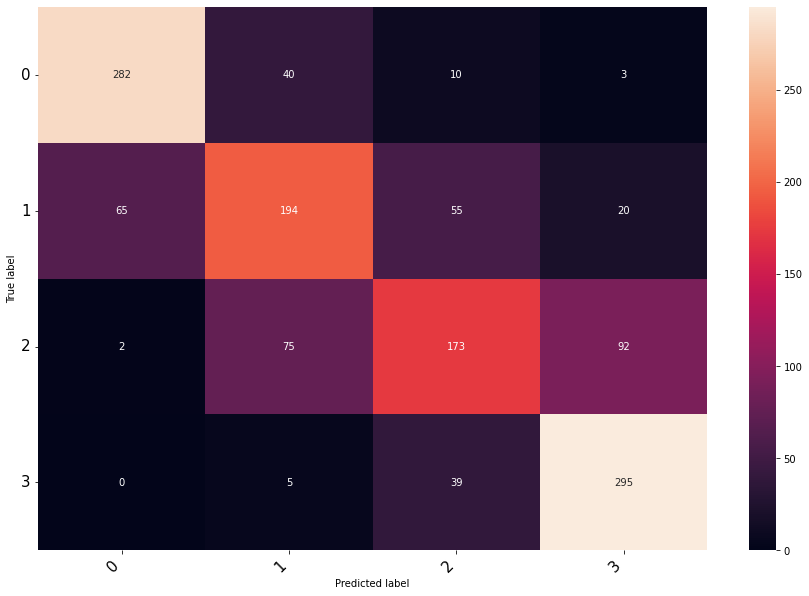

In [62]:
cm.visualize()

In [63]:
cm.class_accuracy

tensor([0.8418, 0.5808, 0.5058, 0.8702])

In [64]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.13460696, 0.16233161, 0.13889697, 0.11499597]

In [65]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.08846276, 0.11627883, 0.11214795, 0.07417062]

### GAT

In [66]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[True, False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [67]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

100%|██████████| 576/576 [1:02:27<00:00,  6.51s/it]


#### Results

In [68]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 7598/7598 [06:58<00:00, 18.14it/s]


In [69]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.29799933628886566,
 'epoch': 90,
 'train_loss': 0.04011719,
 'val_loss': 0.031720746,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.4666665494441986,
 'val_rmse_perc': 0.18146789,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.47_4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2_90',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.7745966692414834,
 'test_rmse': 0.8919392106839769,
 'train_mae': 0.4857142857142857,
 'val_mae': 0.5555555555555556,
 

In [70]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.32574541382322736,
 'epoch': 57,
 'train_loss': 0.048090644,
 'val_loss': 0.03166671,
 'train_acc': 0.5714285373687744,
 'val_acc': 0.48888877034187317,
 'val_rmse_perc': 0.18083762,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.49_4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2',
 'train_rmse': 0.7745966692414834,
 'val_rmse': 0.7601169500660919,
 'test_rmse': 0.9104333522498442,
 'train_mae': 0.4857142857142857,
 'val_mae': 0.5333333333333333,
 't

In [71]:
all = res_edges[2]

sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25],
 'out_features': 1,
 'num_heads': [4, 2],
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'negative_slope': 0.4,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'tr_par_lr': 0.01,
 'tr_par_optimizer_name': 'adamw',
 'tr_par_scheduler_mode': 'max_val_mcc',
 'tr_par_use_edge_weight': True,
 'tr_par_loss_type': 'mse',
 'tr_par_approach': 'dist',
 'tr_par_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'val_mcc': 0.29799933628886566,
 'epoch': 100,
 'train_loss': 0.049218714,
 'val_loss': 0.03169385,
 'train_acc': 0.5619047284126282,
 'val_acc': 0.4666665494441986,
 'val_rmse_perc': 0.18145373,
 'model_class': 'gat',
 'path_name': 'saved_gat\\0.47_4_[25_25]_1_[4_2]_gn_ReLU()_0.4_0.2_0.2_True_0.01_adamw_max_val_mcc_True_mse_dist_10_True_0.2_100',
 'train_rmse': 0.7622023228463561,
 'val_rmse': 0.7745966692414834,
 'test_rmse': 0.8915238722630006,
 'train_mae': 0.4857142857142857,
 'val_mae': 0.5555555555555556,

In [72]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 7598/7598 [00:00<00:00, 20834.69it/s]
